In [41]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample, shuffle
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [42]:
data = pd.read_csv("C:/Users/Akif/Desktop/football/rankingv5v3.csv")

In [43]:
home_win = data[data['result'] == 1]
away_win = data[data['result'] == 2]
draw = data[data['result'] == 0]

In [44]:
draw_upsampled = resample(draw, replace=True, n_samples=len(home_win), random_state=42)
away_win_upsampled = resample(away_win, replace=True, n_samples=len(home_win), random_state=42)

data_balanced = pd.concat([home_win, draw_upsampled, away_win_upsampled])
data_balanced = shuffle(data_balanced, random_state=42)

In [45]:
selected_columns = [
    'home_club_id', 'away_club_id', 'attendance', 'result', 'home_team_points', 'away_team_points',
    'home_attack_value', 'away_attack_value', 'home_midfield_value',
    'away_midfield_value', 'home_defender_value', 'away_defender_value',
    'home_goalkeeper_value', 'away_goalkeeper_value',
    'home_total_market_value', 'away_total_market_value',
    'home_power_score', 'away_power_score'
]
data = data_balanced[selected_columns]

In [46]:
X = data.drop('result', axis=1)
y = data['result']

In [47]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [48]:
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(y.values.reshape(-1, 1))

In [49]:
X, y = shuffle(X, y, random_state=42)

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2

def create_complex_model(optimizer='adam', learning_rate=0.001, dropout_rate=0.3, neurons=128, activation='relu', l2_lambda=0.01):
    model = Sequential()

    model.add(Dense(neurons, input_shape=(X.shape[1],), kernel_regularizer=l2(l2_lambda)))
    model.add(BatchNormalization())
    model.add(LeakyReLU() if activation == 'leaky_relu' else Activation(activation))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(neurons, kernel_regularizer=l2(l2_lambda)))
    model.add(BatchNormalization())
    model.add(LeakyReLU() if activation == 'leaky_relu' else Activation(activation))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(neurons//2, kernel_regularizer=l2(l2_lambda)))
    model.add(BatchNormalization())
    model.add(LeakyReLU() if activation == 'leaky_relu' else Activation(activation))
    model.add(Dropout(dropout_rate + 0.1))
    
    model.add(Dense(neurons//4, kernel_regularizer=l2(l2_lambda)))
    model.add(BatchNormalization())
    model.add(LeakyReLU() if activation == 'leaky_relu' else Activation(activation))
    model.add(Dropout(dropout_rate + 0.2))

    model.add(Dense(neurons//8, kernel_regularizer=l2(l2_lambda)))
    model.add(BatchNormalization())
    model.add(LeakyReLU() if activation == 'leaky_relu' else Activation(activation))
    model.add(Dropout(dropout_rate + 0.3))
    
    model.add(Dense(3, activation='softmax'))
    
    optimizer_instance = Adam(learning_rate=learning_rate) if optimizer == 'adam' else RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=optimizer_instance, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [51]:
model = KerasClassifier(build_fn=create_model, verbose=0)

C:\Users\Akif\AppData\Local\Temp\ipykernel_12188\2566461152.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


In [52]:
param_grid = {
    'batch_size': [64],
    'epochs': [40],
    'optimizer': ['rmsprop'],
    'learning_rate': [0.0001],
    'dropout_rate': [0.4],
    'neurons': [1024],
    'activation': ['leaky_relu']
}

kf = KFold(n_splits=3, shuffle=True, random_state=42)

In [53]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, n_jobs=-1, verbose=1)
grid_result = grid.fit(X, y)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [54]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, n_jobs=-1, verbose=2)
grid_result = grid.fit(X, y)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [55]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, n_jobs=-1, verbose=3)
grid_result = grid.fit(X, y)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [56]:
print(f"Best Parameters: {grid_result.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_result.best_score_}")

Best Parameters: {'activation': 'leaky_relu', 'batch_size': 64, 'dropout_rate': 0.4, 'epochs': 40, 'learning_rate': 0.0001, 'neurons': 1024, 'optimizer': 'rmsprop'}
Best Cross-Validation Accuracy: 0.48563958207766217


In [57]:
best_model = grid_result.best_estimator_

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [59]:
best_model.fit(X_train, y_train)

In [60]:
y_pred = best_model.predict(X_test)
y_true_classes = np.argmax(y_test, axis=1)


print(classification_report(y_true_classes, y_pred))

192/192 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.39      0.36      0.38      2055
           1       0.52      0.53      0.53      2074
           2       0.52      0.55      0.53      1991

    accuracy                           0.48      6120
   macro avg       0.48      0.48      0.48      6120
weighted avg       0.48      0.48      0.48      6120



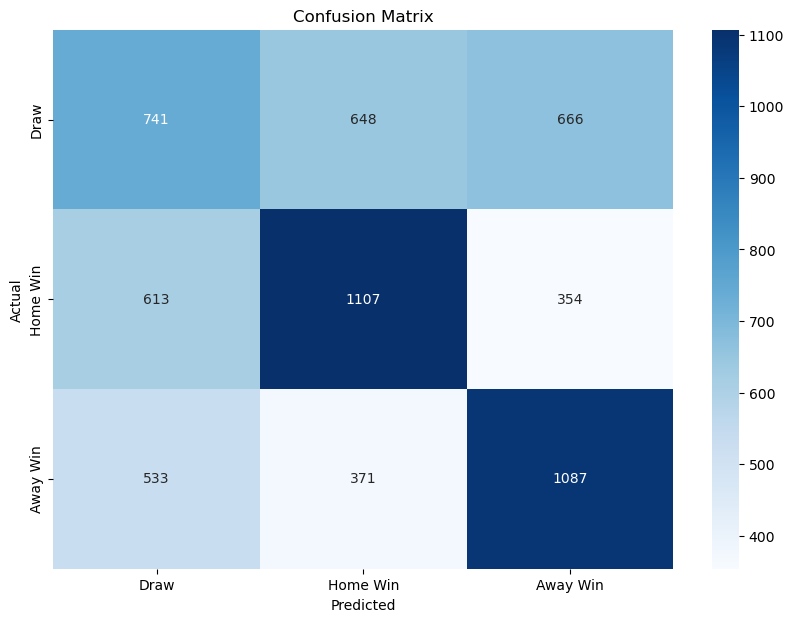

In [61]:
conf_matrix = confusion_matrix(y_true_classes, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Draw', 'Home Win', 'Away Win'], yticklabels=['Draw', 'Home Win', 'Away Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [27]:
history = best_model.model.history.history
plt.plot(history['accuracy'], label='accuracy')
plt.plot(history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

KeyError: 'accuracy'